In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as ut
import matplotlib as mpl

In [34]:
# this string must be passed during the execution of gillespie_test.exe
data_dir = '../data/chem_evol_e1/'

In [39]:
params = dict()

# LV parameters
params['process_type'] = 'chem_evole'
#params['delta0'] = 1
params['eta0'] = 1
params['alpha0'] = 0.01
params['M'] = 200
params['mut_rate'] = 0.00002
params['alpha_max'] = params['alpha0']*params['M']*1.5
n_states = 12
params['delta_alpha'] = params['alpha_max']/n_states

#params['alphas'] = np.logspace(np.log10(0.4), np.log10(4), n_states)
#print(params['alphas'])


# Gillespie parameters
params['end_cond'] = 'time'
params['max_steps'] = 600000000
params['traj_step'] = params['max_steps']/2000
#params['init_state'] = np.ones(n_states) * params['M'] / n_states # Initial condition
params['init_state'] = np.zeros(n_states)
params['init_state'][-1] = params['M']
params['r_start'] = 0
params['N_realizations'] = 15

In [40]:
ut.write_params(params, data_dir, 'param.txt')

### Import

In [17]:
data_dir = '../data/chem_evol_e_log/'
plot_dir = '../plots/chem_evol/'
params = ut.read_params(data_dir+'param.txt')
#n_states = int(params['alpha_max']/params['delta_alpha'])
n_states = len(params['alphas'])
print(params)

{'process_type': 'chem_evole', 'eta0': 1.0, 'alpha0': 0.01, 'M': 200.0, 'mut_rate': 2e-05, 'alphas': array([0.4       , 0.4931387 , 0.60796443, 0.74952697, 0.92405188,
       1.13921435, 1.40447669, 1.73150451, 2.13467969, 2.6317329 ,
       3.24452332, 4.        ]), 'end_cond': 'time', 'max_steps': 600000000.0, 'traj_step': 300000.0, 'init_state': array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       200.]), 'r_start': 115.0, 'N_realizations': 15.0}


In [18]:
traj, labels = ut.read_traj(data_dir+'traj0.txt')

In [20]:
N_traj = traj[:,1:].sum(axis=1)
#alphas = np.linspace(params['delta_alpha'], params['alpha_max'], n_states)
alphas = params['alphas']
av_alpha_traj = np.sum(traj[:,1:]*alphas, axis=1) / N_traj
std_alpha_traj = np.sqrt(np.sum(traj[:,1:]*alphas**2, axis=1) / N_traj - av_alpha_traj**2)

<ipython-input-20-9957fad91329>:5: RuntimeWarning: invalid value encountered in sqrt
  std_alpha_traj = np.sqrt(np.sum(traj[:,1:]*alphas**2, axis=1) / N_traj - av_alpha_traj**2)


No handles with labels found to put in legend.


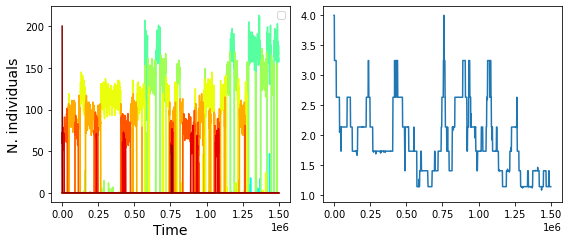

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))
colors = plt.cm.jet(np.linspace(0,1,n_states))
#xlim = [0,len(traj[:,0])]
#xlim = [0,1000]
#ax1.set_ylim([0,300])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('N. individuals',fontsize=14)
#ax1.set_xlim(xlim)
for i in range(len(labels)-1):
    ax1.plot(traj[:,0], traj[:,1:][:,i], c=colors[i])
ax1.legend(fontsize=10)

#ax2.set_xlim(xlim)
ax2.plot(traj[:,0], av_alpha_traj)
ax2.fill_between(traj[:,0], av_alpha_traj-std_alpha_traj/2, av_alpha_traj+std_alpha_traj/2)
plt.tight_layout()
plt.savefig(plot_dir+'traj.png', dpi=200, transparent=True)

In [22]:
cumul_av_alpha = np.zeros(len(av_alpha_traj))
for i in range(len(labels)-1):
    cumul_av_alpha = np.row_stack((cumul_av_alpha, cumul_av_alpha[-1] + traj[:,1:][:,i]))

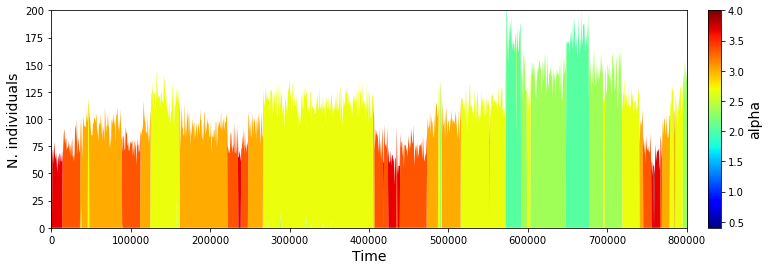

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1) = plt.subplots(1,1,figsize=(12,4))
colors = plt.cm.jet(np.linspace(0,1,n_states))
#xlim = [32000,34000]
#plt.ylim([0,200])
ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('N. individuals',fontsize=14)
ax1.set_xlim([0,800000])
ax1.set_ylim([0,200])
for i in range(len(labels)-1):
    ax1.fill_between(traj[:,0], cumul_av_alpha[i], cumul_av_alpha[i+1], color=colors[i],lw=0)
#ax1.legend(fontsize=10)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.3)
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=alphas[0], vmax=alphas[-1])
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('alpha', fontsize=14)

plt.savefig(plot_dir+'color_traj.png',dpi=200)

In [25]:
#alphas = np.linspace(params['delta_alpha'], params['alpha_max'], n_states)
#alphas = params['alphas']
av_av_alpha = np.zeros(len(av_alpha_traj))
av_times = np.zeros(len(av_alpha_traj))
params['N_realizations'] = 130
snap_times_frac = np.array([0.7,0.8,0.9,1])
snap_times = np.array(snap_times_frac * int(len(av_alpha_traj)-1), dtype=int)
final_dist = np.empty((0,len(snap_times)))
for i in range(int(params['N_realizations'])):
    traj, labels = ut.read_traj(data_dir+'traj'+str(i)+'.txt')
    N_traj = traj[:,1:].sum(axis=1)
    av_alpha_traj = np.sum(traj[:,1:]*alphas, axis=1) / N_traj
    samples = np.take(av_alpha_traj, snap_times)
    final_dist = np.append(final_dist, samples)
    #final_dist.append(av_alpha_traj[int(len(av_alpha_traj)*0.9)])
    av_av_alpha += av_alpha_traj/params['N_realizations']
    av_times += traj[:,0]/params['N_realizations']

In [26]:
def mut_p_inv_ratio(Nts, c):
    e1 = (c+1)/c*(Nts/2 + 1 - c)
    return np.exp(e1)

def c_f(a1, a2, a0):
    return (a1 + a0)/(a2 + a0)

def Nts_f(M, a1, a2, a0):
    return M * a0*(a1-a2)/a1/a2**2

In [27]:
i = 0
Nts = Nts_f(params['M'], alphas[i+1], alphas[i], params['alpha0'])
c = c_f(alphas[i+1], alphas[i], params['alpha0'])
print(alphas[i], alphas[i+1], mut_p_inv_ratio(Nts, c))

0.4 0.4931386957768265 5.641023804440535


In [28]:
dist = np.array([1])
norm = 0
for i in range(len(alphas)-1):
    Nts = Nts_f(params['M'], alphas[i+1], alphas[i], params['alpha0'])
    c = c_f(alphas[i+1], alphas[i], params['alpha0'])
    dist = np.append(dist, dist[-1]*mut_p_inv_ratio(Nts, c))
    norm += dist[-1]*(alphas[i+1] - alphas[i])

In [29]:
average = (alphas*dist).sum()/norm*(alphas[1]-alphas[0])

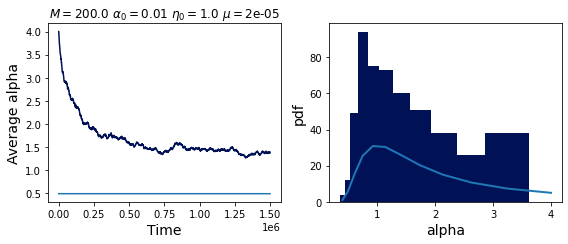

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))

ax2.set_xlabel('alpha', fontsize=14)
ax2.set_ylabel('pdf', fontsize=14)
ax2.plot(alphas, dist, lw=2)
ax2.hist(final_dist, bins=alphas, align='left', color='#001156')

ax1.set_xlabel('Time',fontsize=14)
ax1.set_ylabel('Average alpha',fontsize=14)
ax1.set_title("$M=$"+str(params['M'])+r" $\alpha_0=$"+str(params['alpha0'])+r" $\eta_0=$"+str(params['eta0'])+r" $\mu=$"+str(params['mut_rate']))
ax1.plot(av_times, av_av_alpha, color='#001156')
ax1.plot(av_times, np.ones(len(traj[:,0]))*average)

plt.tight_layout()
plt.savefig(plot_dir+'alpha_stat.png', dpi=200)

In [113]:
average

array([0.25000017, 0.50000034, 0.75000051, 1.00000069, 1.25000086,
       1.50000103, 1.7500012 , 2.00000137, 2.25000154, 2.50000171,
       2.75000188, 3.00000206, 3.25000223, 3.5000024 , 3.75000257,
       4.00000274])